## 3 Data Augmentation 


### data labels별 결과 분석 및 데이터 추가 보강을 통한 정확도 비교


■ 학습 방법 :
* 가장 성능이 좋은 모델(kcbert, lr=5e-5, maxlen=256, batch_size=32)을 대상으로 test set 적용한 결과 분석 
* labels별 결과 분석 : 혼동행렬과 f1, precision, recall 등을 체크
* 현재 데이터의 정확도 향상에 있어 부족한 점이 무엇인지 분석
* 데이터를 추가 보완하게 되면 accuracy 가 높아지는 지 실험

<br><br>
#### (1) 환경 설치 및 라이브러리 임포트 
- [파이토치 설치 (설치환경별 코드 상이)](https://pytorch.org/)

In [10]:
import pandas as pd
import numpy as np
import torch
import transformers
import matplotlib.pyplot as plt

In [11]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# GPU 사용 지정
if torch.cuda.is_available():     
    device = torch.device('cuda')

# If not... CPU 사용 지정
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

<br><br>
#### (2) 데이터 로딩 
- 데이터 탐색 및 전처리 시 저장한 <code>train_data.tsv</code>, <code>test_data.tsv</code> 불러옵니다.
- 각 데이터는 label(예측해야할 값)과 text(예측에 사용될 값)로 이루어져 있습니다.
- 2.1 구글버트에서 로딩했던 방법과 동일합니다.

In [16]:
# Load the dataset 
train = pd.read_csv("data/train_data.tsv", sep ='\t', header=0, encoding='utf-8', names=['label','text'])
test = pd.read_csv("data/test_data.tsv", sep ='\t', header=0, encoding='utf-8', names=['label','text'])

# sentences 개수
print('Training sentences 개수: {:,}'.format(train.shape[0]))
print('Test sentences 개수: {:,}\n'.format(test.shape[0]))

# train/test 각각의 text 와 label을 리스트로 가져옵니다.
train_texts = train.text.values.tolist()
train_labels = train.label.values.tolist()
test_texts = test.text.values.tolist()
test_labels = test.label.values.tolist()

# 데이터 모양 출력
train_texts[:2] , train_labels[:2]

Training sentences 개수: 34,396
Test sentences 개수: 8,327



(['고객님 정보 확인 불가 문의 안녕하세요 당일 고객님 분실정지 진행하려고 하는데 인입시 고객정보가 조회되지 않습니다 처리결과 값이 올바르지 않습니다 라고 나오면 정보조회의 기본정보 성명 생년월일등 가 확인되지 않습니다 해당 내용 확인 부탁 드립니다 감사합니다',
  '긴급 tv m oss 결과보고시 기존바코드 확인안되어hds연동할수 없음 업무경로 데이터 국사 원주 회선번호 수리접수번호 상품정보 서비스계약번호 연락처 이윤범 현장 확인사항 수리오더로 결과보고시 연동시 기존바코드가 올라오지않아 교체업무 진행을 할 수 가 없습니다 완료보고 확인시 기존바코드에 빌트인 로 확인되며 단말원부확인시 댁내설치된기존바코드 확인시 사용 사용으로 되어 있습니다 긴급건으로 확인 및 조치 부탁 드립니다'],
 ['ASM34824', 'ASM31688'])

<br><br>
#### (3) 데이터 포맷 변경 
1. label(Output : y) 정수화 - label 포맷을 str 문자에서 int 정수로 매핑 
2. text(Input : x) 토큰화 - 데이터를 BERT를 학습 할 수 있는 형식으로 변환합니다. \
  . 문장별 토큰화 \
  . vocab 기반 정수 인덱스 매핑 & padding \
  . input text mask 적용 \
  (text 토큰화는 아래 3가지 적용방식에 따로 구현하였으니 참고바랍니다.)

In [17]:
# 1. label(Output : y) 정수 인코딩 
label_idx = {j:i for i,j in enumerate(sorted(set(test.label.values.tolist())))}  # dict{ 'ASM14261' : 0 , 'ASM14262' : 1 , ...} 
print('labels 개수 :',len(label_idx)) 
train_labels = [label_idx[i] for i in train.label.values.tolist()]
test_labels = [label_idx[i] for i in test.label.values.tolist()]
print('Train Data 개수 :',len(train_labels) , '\nTest Data 개수 :',len(test_labels))
print('\n▶ label 정수 인덱스화 예시 :' , test.label.values.tolist()[:3], '->', test_labels[:3] )

labels 개수 : 183
Train Data 개수 : 34396 
Test Data 개수 : 8327

▶ label 정수 인덱스화 예시 : ['ASM14326', 'ASM30034', 'ASM30014'] -> [6, 65, 58]


<br><br>
#### (4) 데이터 예측 결과 분석 (y prediction analysis)
- 저장된 모델 중 test set에 accuracy가 가장 높은 모델을 불러옵니다. (kcbert+mecab적용데이터)
- labels별 결과 분석 : 혼동행렬과 f1, precision, recall 등을 체크합니다.

<code>test set 의 accuracy 및 혼동행렬( F1, precision, recall 포함)을 출력합니다.


**1) Accuracy**
- kcbert , lr = 5e-5 , mecab을 사용 하였을 때 accuracy : 0.7994

In [23]:
# _test.py
import sys
import argparse
import random

import torch
import torch.nn as nn

from transformers import AutoTokenizer
from transformers import BertForSequenceClassification


model_nm = 'bert_bm_loss' # 'bert_bm_loss' 'bert_bm_acc' # best loss 일때의 bert weights를 가져옵니다. 


def define_argparser():
    '''
    Define argument parser to take inference using pre-trained model.
    '''
    p = argparse.ArgumentParser()

    p.add_argument('--model_load', default='kcbert/_params/kcbert_mecab_11.pth')
    p.add_argument('--test_fn', default='data/test_data_mecab.tsv')      
    p.add_argument('--gpu_id', type=int, default=0)
    p.add_argument('--batch_size', type=int, default=8)
    p.add_argument('--top_k', type=int, default=1)

    config = p.parse_args("")

    return config


def read_text(fn):
    with open(fn, 'r') as f:
        lines = f.readlines()

        labels, texts = [], []
        for idx, line in enumerate(lines):
            if idx == 0:
                # header 지우기
                continue
            if line.strip() != '':
                # First column :label field,
                # second column : text field.
                label, text = line.strip().split('\t')
                labels += [label]
                texts += [text]

    return labels, texts

def get_acc(logits, y):
    _, predicted = torch.max(logits.data, 1)
    total = y.size(0)
    correct = (predicted == y).sum().item()
    return correct, total
    
def main(config):
    saved_data = torch.load(
        config.model_load,
        map_location='cpu' if config.gpu_id < 0 else 'cuda:%d' % config.gpu_id
    )

    train_config = saved_data['config']
    bert_best = saved_data[model_nm] 
    index_to_label = saved_data['classes']

    label_to_index = {}
    for key, val in index_to_label.items():
        label_to_index[val] = key
    
    # 테스트 데이터 
    labels, lines = read_text(config.test_fn) # list of texts
    
    # 정답 
    labels = list(map(label_to_index.get, labels))
    
    with torch.no_grad():
        if config.gpu_id >= 0:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        tokenizer = AutoTokenizer.from_pretrained(train_config.pretrained_model_name) # kcbert 토크나이저를 가져옵니다.

        model = BertForSequenceClassification.from_pretrained(
            train_config.pretrained_model_name,
            num_labels=len(index_to_label)
        ) # kcbert 모델구조를 가져옵니다.
        
        # 학습한 모델로 바꿔 넣습니다. 
        model.load_state_dict(bert_best)
        model.to(device)

        model.eval()      
        
        y_hats = []

        tot_correct = 0
        total_n = 0
        for idx in range(0, len(lines), config.batch_size): # y, lines
            mini_batch = tokenizer(
                lines[idx:idx + config.batch_size],
                padding=True,
                truncation=True,
                return_tensors="pt",
            )
            
            y = labels[idx:idx + config.batch_size]
            y = torch.LongTensor(y)
            y = y.to(device)
            
            x = mini_batch['input_ids']
            x = x.to(device)
            mask = mini_batch['attention_mask']
            mask = mask.to(device)

            # Take feed-forward
            y_hat = model(x, attention_mask=mask)[0]
            y_hats += [y_hat]
            
            correct, n = get_acc(y_hat, y)
            tot_correct += correct
            total_n += n            
            
        # accuracy 출력
        print('\n▶Test - |accuracy| :', round(float(tot_correct/total_n),4)) # accuracy를  산출 합니다. 
        
if __name__ == '__main__':
    config = define_argparser()
    main(config)

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali


▶Test - |accuracy| : 0.7994


<br><br>
**2) Confusion Matrix**
- 레이블별 F1 score, recall, precision 체크하기

Test set: 8327
Test labels: 183


Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali


|accuracy| : 0.7994


       ============ Confusion Matrix ============ 

              precision    recall  f1-score   support

    ASM14261       0.00      0.00      0.00         1
    ASM14262       0.00      0.00      0.00         1
    ASM14263       1.00      0.90      0.95        41
    ASM14284       0.78      0.70      0.74        30
    ASM14307       0.00      0.00      0.00         1
    ASM14324       1.00      0.20      0.33         5
    ASM14326       0.34      0.42      0.38        33
    ASM14334       0.00      0.00      0.00         1
    ASM14351       0.94      0.97      0.95        30
    ASM14352       0.77      0.83      0.80        12
    ASM14361       0.00      0.00      0.00         2
    ASM14362       1.00      1.00      1.00         5
    ASM14370       0.89      0.57      0.70        14
    ASM14382       0.75      0.75      0.75         8
    ASM14384       0.87      1.00      0.93        20
    ASM14385       0.90      0.96      0.93        47
    AS

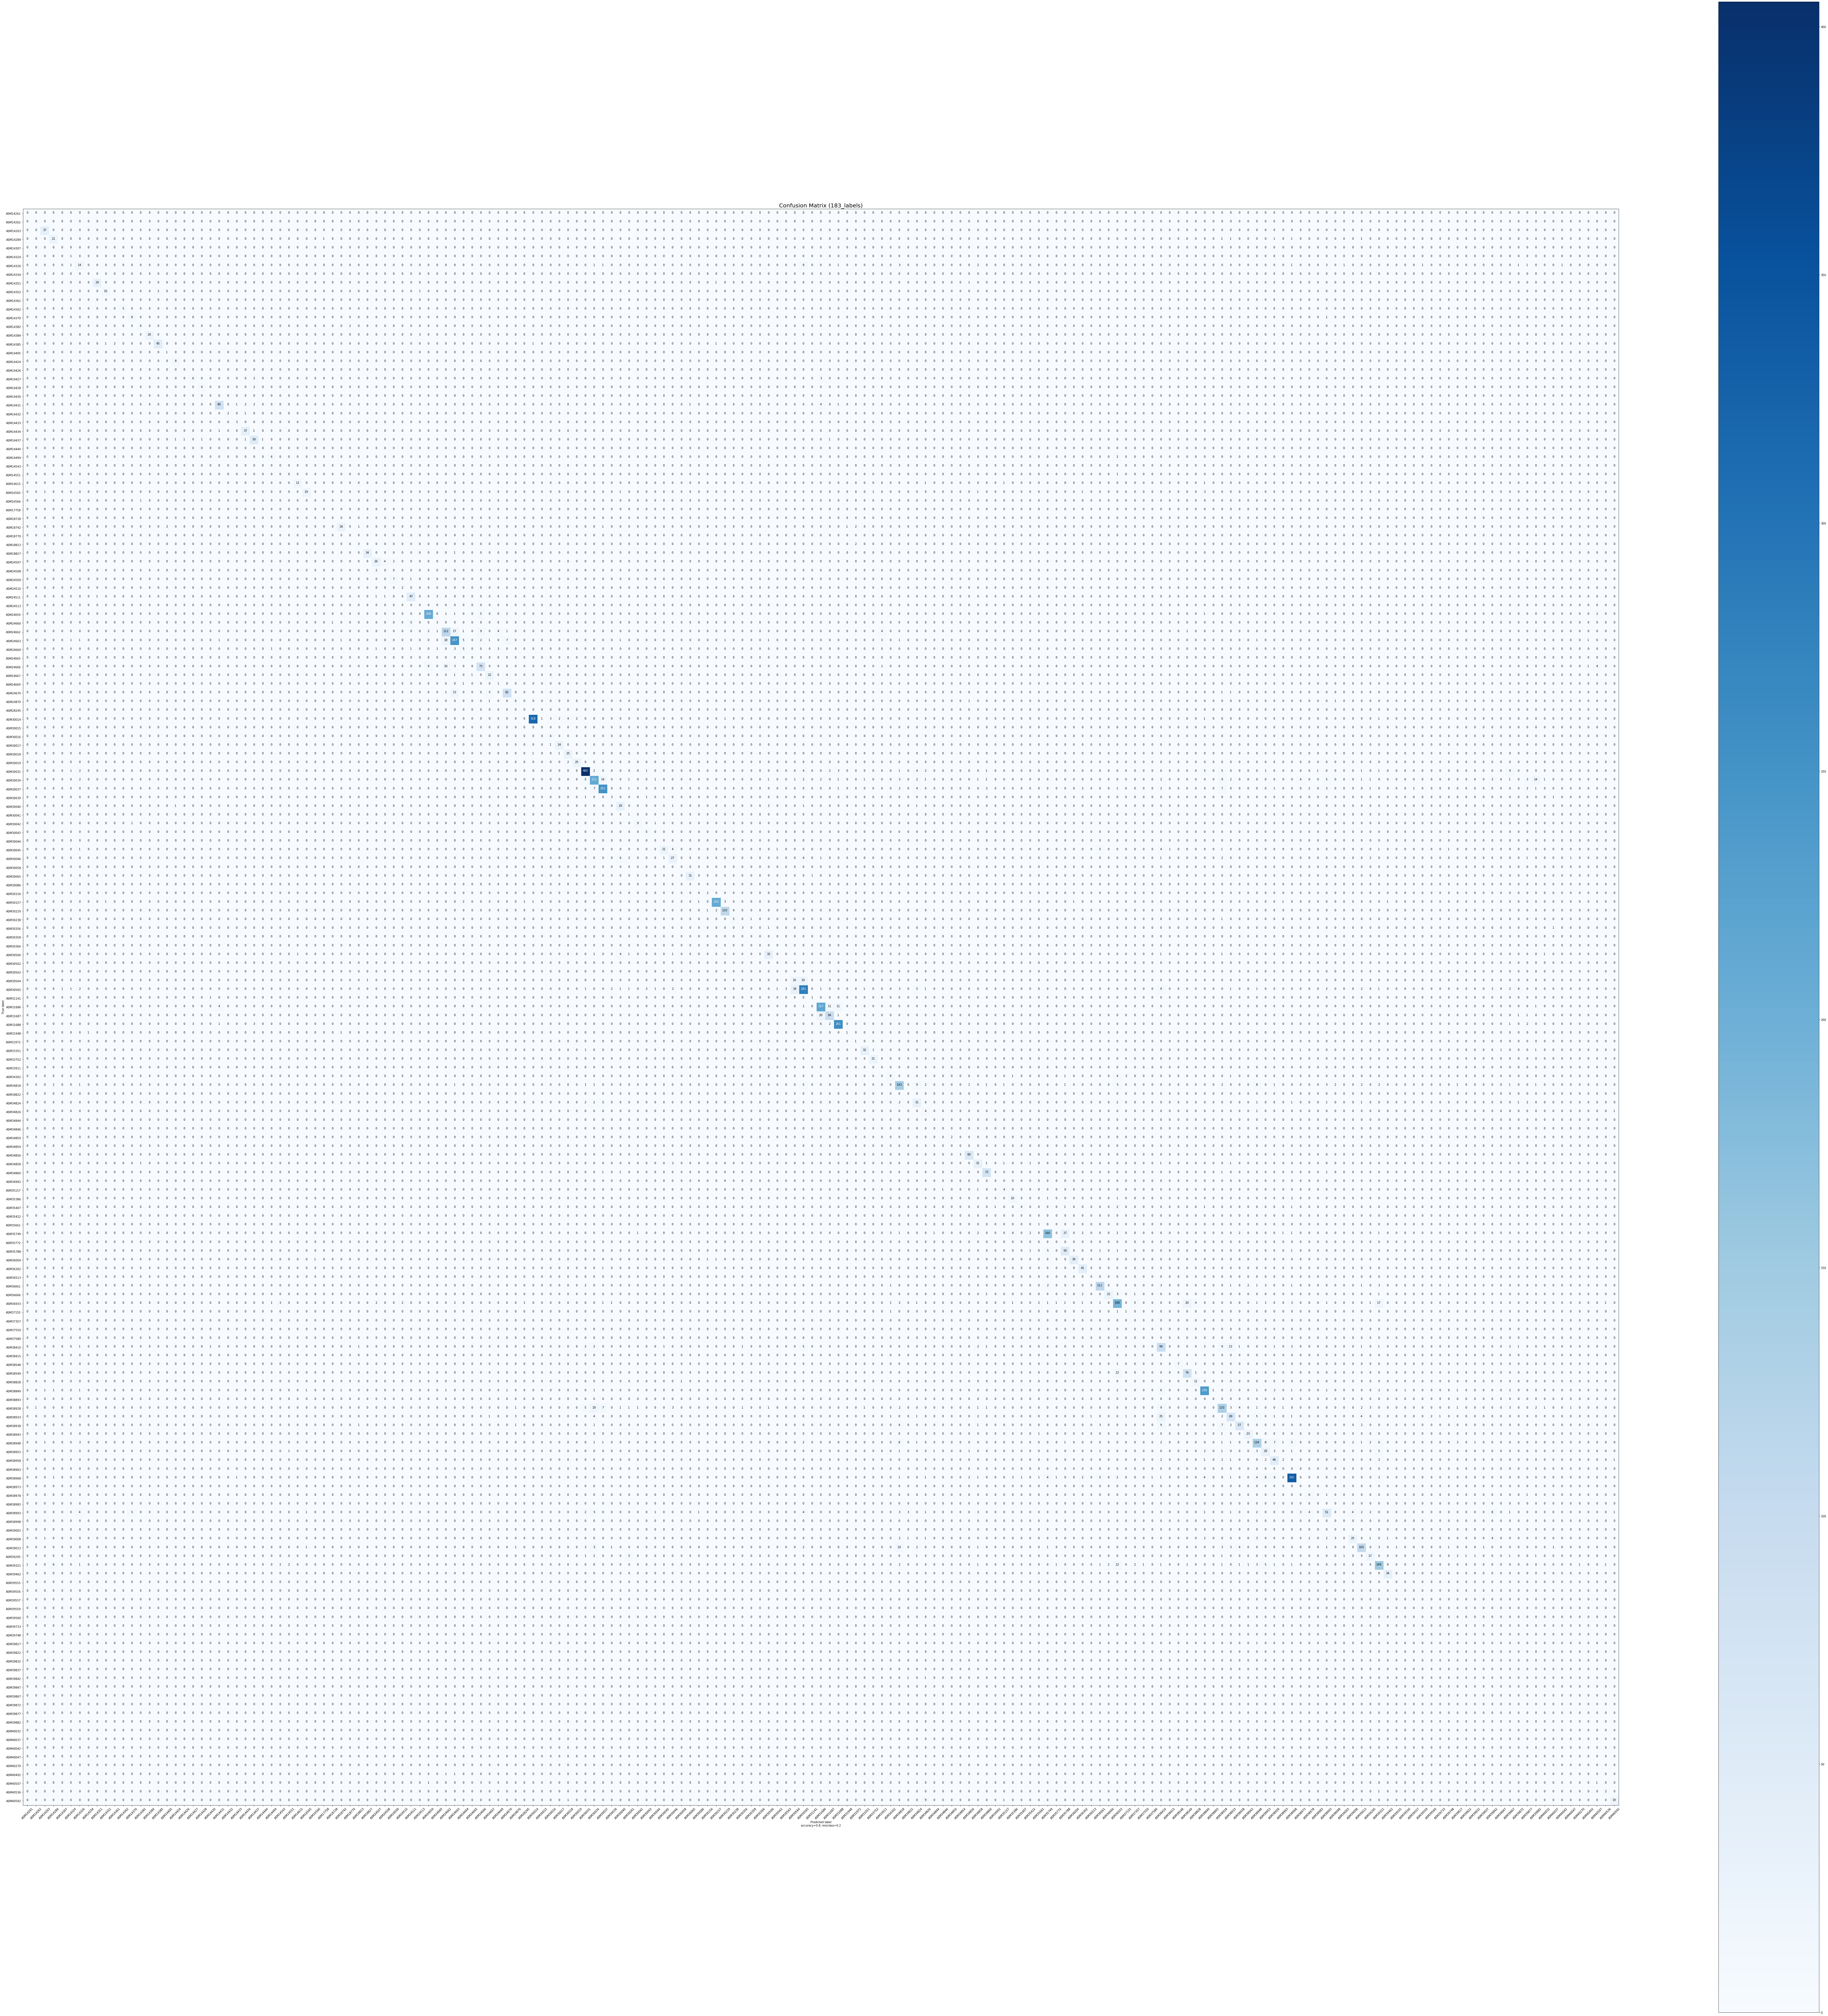

<Figure size 432x288 with 0 Axes>

In [19]:
import sys
import numpy as np
import pandas as pd 

import argparse
import random

import torch
import torch.nn as nn

from transformers import AutoTokenizer
from transformers import BertForSequenceClassification

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model_nm = 'bert_bm_loss' # 'bert_bm_loss' 'bert_bm_acc'

def define_argparser():
    p = argparse.ArgumentParser()
    p.add_argument('--model_load', default='kcbert/_params/kcbert_mecab_11.pth')
    p.add_argument('--test_fn', default='data/test_data_mecab.tsv')   
    p.add_argument('--csv_fn', default='kcbert/_res/confusion.csv') 
    p.add_argument('--txt_fn', default='kcbert/_res/confusion.txt')
    p.add_argument('--plt_fn', default='kcbert/_res/confusion.png') 
    p.add_argument('--csv_fn2', default='kcbert/_res/pred_y_compare.csv') 
    p.add_argument('--gpu_id', type=int, default=0)
    p.add_argument('--batch_size', type=int, default=32)
    p.add_argument('--top_k', type=int, default=1)

    config = p.parse_args("")

    return config

def read_text(fn):
    with open(fn, 'r') as f:
        lines = f.readlines()

        labels, texts = [], []
        for idx, line in enumerate(lines):
            if idx == 0:
                continue
            if line.strip() != '':
                label, text = line.strip().split('\t')
                labels += [label]
                texts += [text]

    return labels, texts

def get_loaders(fn2, tokenizer):
    labels_t, texts_t = read_text(fn2) # test.tsv 
    
    len_test = len(labels_t)

    labels_t = list(map(label_to_index.get, labels_t))

    test_loader = DataLoader(
        BertDataset(texts_t, labels_t),
        batch_size=config.batch_size,
        collate_fn=TokenizerWrapper(tokenizer, config.max_length).collate,
    )    
    return index_to_label , test_loader , len_test

def get_acc(logits, y):
    _, predicted = torch.max(logits.data, 1)
    total = y.size(0)
    correct = (predicted == y).sum().item()
    return correct, total

def get_confusion_matrix(classes, y, y_hat):
    confusion_matrix = np.zeros((len(classes), len(classes)))
    mapping_table = {}

    for idx, c in enumerate(classes):
        mapping_table[c] = idx

    for y_i, y_hat_i in zip(y, y_hat):
        confusion_matrix[mapping_table[y_hat_i], mapping_table[y_i]] += 1
        
    dataframe = pd.DataFrame(confusion_matrix)
    dataframe.columns = classes
    dataframe.index= classes
    dataframe.to_csv(config.csv_fn, header=True, index=True, index_label ='label_183')
   
    return confusion_matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    
    SMALL_SIZE = 10
    MEDIUM_SIZE = 15
    BIGGER_SIZE = 20

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels MEDIUM_SIZE
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title BIGGER_SIZE
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(1000, 1000))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45,)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(int(cm[i, j])),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.1f}; misclass={:0.1f}'.format(accuracy, misclass))
    plt.show()
    fig = plt.gcf()
    fig.savefig(config.plt_fn, dpi=fig.dpi)
    
def main(config):
    saved_data = torch.load(
        config.model_load,
        map_location='cpu' if config.gpu_id < 0 else 'cuda:%d' % config.gpu_id
    )

    train_config = saved_data['config']
    bert_best = saved_data[model_nm]  # 'bert' 'bert_bm_loss' 'bert_bm_acc'
    index_to_label = saved_data['classes']

    label_to_index = {}
    for key, val in index_to_label.items():
        label_to_index[val] = key
    
    # 테스트 데이터 
    labels_tx, lines = read_text(config.test_fn) # list of texts
    
    # 정답 
    labels = list(map(label_to_index.get, labels_tx))
    
    print('Test set:' ,len(labels_tx))
    print('Test labels:' ,len(set(labels_tx)))
    
    # test.tsv : labels , lines  : raw list 인풋
    with torch.no_grad():
        if config.gpu_id >= 0:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Declare model and load pre-trained weights.
        tokenizer = AutoTokenizer.from_pretrained(train_config.pretrained_model_name)
        model = BertForSequenceClassification.from_pretrained(
            train_config.pretrained_model_name,
            num_labels=len(index_to_label)
        )
        
        # 학습된 모델로 갈아끼워넣기
        model.load_state_dict(bert_best)
        model.to(device)

        model.eval()  
        
        y_hats = []

        tot_correct = 0
        total_n = 0
        for idx in range(0, len(lines), config.batch_size): # y, lines
            mini_batch = tokenizer(
                lines[idx:idx + config.batch_size],
                padding=True,
                truncation=True,
                return_tensors="pt",
            )
            
            y = labels[idx:idx + config.batch_size]
            y = torch.LongTensor(y)
            y = y.to(device)
            
            x = mini_batch['input_ids']
            x = x.to(device)
            mask = mini_batch['attention_mask']
            mask = mask.to(device)

            # Take feed-forward
            y_hat = model(x, attention_mask=mask)[0]
            y_hats += [y_hat]
            
            correct, n = get_acc(y_hat, y)
            tot_correct += correct
            total_n += n

#         print('Test - |accuracy| :', float(tot_correct/total_n))
        labels = torch.LongTensor(labels)
        labels = labels.to(device)
        y_hats = torch.cat(y_hats, dim=0)  # |y_hats| = (len(lines), n_classes) # Concatenate the mini-batch wise result
        
        # y : must LongTensor (if float: meaning regression )
        if isinstance(labels, torch.LongTensor) or isinstance(labels, torch.cuda.LongTensor):
            accuracy = (torch.argmax(y_hats, dim=-1) == labels).sum() / float(labels.size(0))
        else:
            accuracy = 0

        print('\n▶ Test - |accuracy| :', round(float(tot_correct/total_n),4) )

        # confusion matrix
        probs, indice = y_hats.topk(config.top_k) # y_hats.cpu().topk(config.top_k)
        # |indice| = (len(lines), top_k)
        #print(len(indice)) # 8327
        #print(indice[0])   # tensor([ 65,  64, 149])
        
        y_pred_k = []
        for i in range(len(lines)):
            temp = [index_to_label[int(indice[i][j])] for j in range(config.top_k)]
            y_pred_k.append(temp)
        #print(len(y_pred_k)) # 8327
        #print(y_pred_k[0])   # [['ASM30034', 'ASM30031', 'ASM38993']]
        #print(labels_tx[:5])
        #print(y_pred_k[:5])
        
        classes = sorted(set(labels_tx))
        
        y_pred_list =[]
        for k in y_pred_k:
            y_pred_list.append(k[0])
        
#         print('confusion matrix classes :', len(classes))
#         print('test set: ', print(len(y_pred_list)) )
          
        # 1 .csv 혼동행렬 출력
        get_confusion_matrix(classes, labels_tx, y_pred_list)
        
        # 2 .txt 혼동행렬 리포트 출력
        with open(config.txt_fn, "a") as f:
            f.write(classification_report(labels_tx, y_pred_list, target_names=classes))

        print("\n\n       ============ Confusion Matrix ============ \n")
        print(classification_report(labels_tx, y_pred_list, target_names=classes)) # target_names=['class 0', 'class 1']
    
        # 3 .png 출력
        plot_confusion_matrix(cm = get_confusion_matrix(classes, labels_tx, y_pred_list), 
                      normalize    = False,
                      target_names = classes,
                      title        = "Confusion Matrix (183_labels)")
        
        # 4 .csv  틀린 값 비교 
        data = pd.read_table(config.test_fn,sep='\t')
        data['pred_y'] = y_pred_list
        data['TF'] = 0
        data.loc[data['label'] == data['pred_y'],'TF'] = 1
        
        data.to_csv(config.csv_fn2, header=True)
        
if __name__ == '__main__':
    config = define_argparser()
    main(config)

(확대 버전은 파일 참고 : confusion.png)

> 혼동 행렬을 확인결과, \
> 전체 정확도는 79.9%(반올림하여 80%)로 높지만 개별 label(레이블)의 정확도를 살펴보면, \
> 데이터 건수(support)가 약 10건 미만의 label의 경우 정확도가 0.0 이거나 매우 낮은 것을 확인할 수 있습니다. \
> 이 부분을 과거 3년치 추가 데이터로 보완을 하게 되었을 때, 부족한 레이블이 채워지면 전체적인 정확도가 좀 더 향상 가능 함을 예상해 볼 수 있습니다. 

<br><br>
**3) 결과 해석**
- TF 열을 통해 맞췄으면 1, 틀렸으면 0으로 체크해 보았습니다.

In [36]:
res = pd.read_csv('kcbert/_res/pred_y_compare.csv',header=0)
res.head(10)

,Unnamed: 0,label,text,pred_y,TF
0,0,ASM14326,인터넷 신청 자동 문자 발송 여부 확인 부탁 드립니다 안녕 하 세요 상담 품질 컨설...,ASM14326,1
1,1,ASM30034,kos 인터넷 bus 외 개 회선 인터넷 일괄 해 지 접수 했 는데 해지 오더 가 ...,ASM30034,1
2,2,ASM30014,유선 에서 무선 으로 변경 후 로그인 안 됨 문 의 유선 에서 무선 으로 변경 후 ...,ASM30014,1
3,3,ASM34860,kos 일반 전화 캠페인 수 행건 삭제 및 재등록 불가 하 여 문 의 시스템 데이터...,ASM34860,1
4,4,ASM30031,재문 의 srm kos 인터넷 전화 설 변 오더 등록 한 처리 자 문 의 재문 의 ...,ASM30031,1
5,5,ASM24666,준공 등록 오류 안녕 하 세요 원주 지사 김진호 입니다 준공 등록 시 오류 메세지 ...,ASM24666,1
6,6,ASM30017,유선 네트워크 연결 이 안 됨 문 의 여승 은 유선 네트워크 연결 이 안 됨 문 의...,ASM30017,1
7,7,ASM38849,선처리 요청 드립니다 개통 단말기 시점 재고 조회 되 어 문의 srm 조직 정보 위...,ASM38849,1
8,8,ASM38410,kos 유선 일반 전화 해지 접수 했 는데 실비 수납 환급 미처리 자료 가 존재 하...,ASM30565,0
9,9,ASM38968,지니 팩 mb 바꿔 쓰 기 설정 시 발생 메세지 문 의 선 검토 내역 경로 데이터 ...,ASM38968,1


In [24]:
# 맞추지못한 1670개 
res.loc[res.TF == 0,]

,Unnamed: 0,label,text,pred_y,TF
8,8,ASM38410,kos 유선 일반 전화 해지 접수 했 는데 실비 수납 환급 미처리 자료 가 존재 하...,ASM30565,0
11,11,ASM30037,tv 약정 만료 일자 상 이 합니다 확인 부탁 드립니다 도신 호 약정 만료 일자 일...,ASM38928,0
13,13,ASM37357,고객 센터 app 로그인 후 이 용량 조회 충전 메뉴 진입 시 재 로그인 현상 문 ...,ASM39321,0
14,14,ASM18742,청구 예정 일자 만 변경 하 려고 순번 번 째 날짜 변경 하 고 저장 하 면 판매 ...,ASM24663,0
17,17,ASM14361,메일 발 송시 대상 서버 에서 배달 알림 을 보내 지 않 았 습니다 발생 문 의 이...,ASM14385,0
...,...,...,...,...,...
8302,8302,ASM30037,제한 적 인터넷 취소 요금 서비스 요청 운영 사용 자 내용 제한 적 인터넷 재 가입...,ASM30034,0
8305,8305,ASM38928,결합 위약금 확인 부탁 드립니다 김금희 고객 님 건 입니다 결합 약정 이 일 까지 ...,ASM39295,0
8310,8310,ASM36933,재문 의 srm shub voc api 문 의 안녕 하 세요 개발 운영 지원 입니다...,ASM38549,0
8319,8319,ASM24663,대양 산업 상행선 kt 청구 변경 요청 드립니다 년 월 추가 공사 처리 로 청구 방...,ASM24670,0


In [37]:
# test set dataframe 불러오기 
test_df = pd.read_csv("data/test_df.tsv", sep ='\t', header=0, encoding='utf-8')

In [52]:
# label 명칭 db 만들기
label_name = test_df[['최종처리그룹','최종처리그룹명']].drop_duplicates('최종처리그룹', keep='first').reset_index(drop=True) 
label_name.columns = ['label','label_name']

# 정답 label 의 명칭 join
res2 = pd.merge(res, label_name, on='label')

# 예측한 label 의 명칭 join
label_name.columns = ['pred_y','pred_y_name']
res3 = pd.merge(res2, label_name, on='pred_y')

In [68]:
# 맞추지 못한 1670개 
res3.loc[res3.TF == 0,['TF','text ','label','label_name','pred_y','pred_y_name']]

,TF,text,label,label_name,pred_y,pred_y_name
14,0,재문 의 srm 인터넷 문자 발송 이력 문 의 시스템 데이터 모바일 인터넷 확인 사...,ASM30034,KOS-요금_ICIS_NS(QOOK인터넷)_서비스요청_운영,ASM14326,KOS-요금_ICIS_공통(고객)_서비스요청_운영
15,0,일 건 차단 해제 처리 후 문자 발송 차 단건 관련 확인 요청 이명호 고객 님 일 ...,ASM38968,KOS-오더_KOS-Customer_KOS-모바일연동_서비스요청_2선,ASM14326,KOS-요금_ICIS_공통(고객)_서비스요청_운영
16,0,시스템 자동 발송 문자 타인 에게 발송 되 어 오류 내역 확인 요청 고객 연락처 가...,ASM30037,KOS-요금_ICIS_NS(QOOKTV)_서비스요청_운영,ASM14326,KOS-요금_ICIS_공통(고객)_서비스요청_운영
17,0,kos kt 서대전 지사 에서 이동식 고객 한테 압류 요청 이 들어간 자료 가 있 ...,ASM30565,KOS-요금_ICIS_집전화_서비스요청_운영,ASM14326,KOS-요금_ICIS_공통(고객)_서비스요청_운영
18,0,kos 일반 전화 명의 변경 복수 처리 진행 시 영업용 매출 평가 회선 으로 확인 ...,ASM30565,KOS-요금_ICIS_집전화_서비스요청_운영,ASM14326,KOS-요금_ICIS_공통(고객)_서비스요청_운영
...,...,...,...,...,...,...
8247,0,kos 와이브로 응용 서비스 id skku 해지 공사 명령 완료 처리 되 지 않 아...,ASM30044,KOS-요금_ICIS_NS(네스팟)_서비스요청_운영,ASM30042,KOS-요금_ICIS_NS(와이브로)_서비스요청_운영
8248,0,각 시스템 별 월 접속 로 그 안녕 하 세요 kt ds 그룹 사업 팀 심재 화 입니...,ASM24507,kt telecop 경영전산_고객센터_고객센터_서비스요청_운영,ASM24508,kt telecop 경영전산_원가관리_원가_서비스요청_운영
8249,0,각 시스템 별 월 월 접속 로 그 안녕 하 세요 kt ds 심재 화 입니다 정보 보...,ASM24507,kt telecop 경영전산_고객센터_고객센터_서비스요청_운영,ASM24508,kt telecop 경영전산_원가관리_원가_서비스요청_운영
8299,0,로그인 기록 확인 요청 목 용산 유선 일반 상담 센터 세일즈 그룹 팀 이로운 당일 ...,ASM30058,CRM(WI 상담지식)(ISC),ASM38828,인증플랫폼_SHUB_OSCA_서비스요청_2선


> 틀리게 예측한 사례를 살펴보면, \
> <code>ASM24507 : kt telecop 경영전산_고객센터_고객센터_서비스요청_운영 , ASM24508 : kt telecop 경영전산_원가관리_원가_서비스요청_운영</code> 처럼 비슷한 성격의 상담내용을 잘 구분하지 못하거나 \
> kos 요금의 경우 하위 성격의 코드로 보이는 ASM30034, ASM38968 , ASM30037, ASM30565 같은 경우는 , \
> 상위 성격의 코드로 보이는 <code>ASM14326 : KOS-요금_ICIS_공통(고객)_서비스요청_운영</code> 로 예측이 되는 것을 볼 수 있습니다.


<br><br>
#### (5) 데이터 추가하기


**1) 과거 3.5년간의 추가 데이터 불러오기**

   ㅇ 대상 : IT VOC 상담 처리 데이터 - 1.5, 2선 대상 \
   ㅇ 기간 : <code>2015.01 ~ 2018.06 (3.5년)</code>


In [18]:
import pandas as pd

data_2015_1 = pd.read_excel('data/_past_data_all/서비스문의_201501-04.xls',  header=0)
data_2015_2 = pd.read_excel('data/_past_data_all/서비스문의_201505-08.xls',  header=0)
data_2015_3 = pd.read_excel('data/_past_data_all/서비스문의_201509-12.xls',  header=0)

data_2016_1 = pd.read_excel('data/_past_data_all/서비스문의_201601-04.xls',  header=0)
data_2016_2 = pd.read_excel('data/_past_data_all/서비스문의_201605-08.xls',  header=0)
data_2016_3 = pd.read_excel('data/_past_data_all/서비스문의_201609-12.xls',  header=0)

data_2017_1 = pd.read_excel('data/_past_data_all/서비스문의_201701-04.xls',  header=0)
data_2017_2 = pd.read_excel('data/_past_data_all/서비스문의_201705-06.xls',  header=0)
data_2017_3 = pd.read_excel('data/_past_data_all/서비스문의_201707-08.xls',  header=0)
data_2017_4 = pd.read_excel('data/_past_data_all/서비스문의_201709-12.xls',  header=0)

data_2018_1 = pd.read_excel('data/_past_data_all/서비스문의_201801-04.xls',  header=0)
data_2018_2 = pd.read_excel('data/_past_data_all/서비스문의_201805-06.xls',  header=0)

print(data_2015_1.shape)
print(data_2015_2.shape)
print(data_2015_3.shape)

print(data_2016_1.shape)
print(data_2016_2.shape)
print(data_2016_3.shape)

print(data_2017_1.shape)
print(data_2017_2.shape)
print(data_2017_3.shape)
print(data_2017_4.shape)

print(data_2018_1.shape)
print(data_2018_2.shape)

data_past = pd.concat([data_2015_1,data_2015_2,data_2015_3,
                       data_2016_1,data_2016_2,data_2016_3,
                       data_2017_1,data_2017_2,data_2017_3,data_2017_4,
                       data_2018_1,data_2018_2
                      ],axis=0)

print('\n총 데이터 개수와 컬럼 개수 :' ,data_past.shape)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
(56512, 18)
(48117, 18)
(46397, 18)
(51467, 18)
(49995, 18)
(43747, 18)
(44873, 18)
(35514, 18)
(31253, 18)
(37456, 18)
(368

In [10]:
# 데이터 예시 (2015-01-01)
data_past.head(2)

,서비스문의 ID,도메인ID,서비스ID,등록일,요청자ID,요청자부서ID,제목,내용,문의유형1,문의유형2,VOC코드1,VOC코드2,VOC코드3,최종 지원 단계,최종처리그룹,최종처리그룹명,작업그룹,작업그룹명
0,SRM15010198337,COD_00040,OG0102,2015-01-01,10108410,394870_1001,[인터넷] 불필요명령삭제요청,고창국사 명령번호**-*** ****-**-** 일자 명령삭제부탁해요,불만문의,DB보정,서비스지원,작업진행관리,작업현황모니터링,2선,ASM31688,OSS_OSS-OM_WFM_서비스요청_운영,ASM30703,ISC_서비스요청_G-OSS
1,SRM15010198346,COD_02129,ISV10000,2015-01-01,91018552,NaN,oc 재설치 요청 / 010-9600-9065,정하연\n***-****-****\n** 재설치 요청\n대구 동구 신암*동 ***-...,불만문의,설치,S/W,OS,NaN,1.5선,ASM30285,OA대구(ISC),ASM30007,ISC_서비스요청_기반인프라


<br><br>
**2) 기존 Data 불러오기**
(intro 에서 데이터 불러오기와 동일 과정)

   ㅇ 대상 : IT VOC 상담 처리 데이터 \
   ㅇ 기간 : <code>2018.07 ~ 2019.05 (11개월) </code>
    

In [ ]:
data_2018_1 = pd.read_csv('data/data_all/2018_sheet1.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2018_2 = pd.read_csv('data/data_all/2018_sheet2.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2018_3 = pd.read_csv('data/data_all/2018_sheet3.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2018_4 = pd.read_csv('data/data_all/2018_sheet4.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2018_5 = pd.read_csv('data/data_all/2018_sheet5.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2019_1 = pd.read_csv('data/data_all/2019_sheet1.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2019_2 = pd.read_csv('data/data_all/2019_sheet2.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2019_3 = pd.read_csv('data/data_all/2019_sheet4.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2019_4 = pd.read_csv('data/data_all/2019_sheet5.txt', header = 0,sep = "\t" ,encoding='cp949' )

# 합치기 (원천데이터이며 이안에 test data도 포함되어 있기에 제외작업 필요)
data_all = pd.concat([data_2018_1,data_2018_2,data_2018_3,data_2018_4,data_2018_5,data_2019_1,data_2019_2,data_2019_3,data_2019_4],axis=0)
# 2) 작년 po부서에서 정확도 산정에 쓰인 test set 불러오기 
test = pd.read_table('data/data_all/test.tsv' ,sep = "\t" ,encoding='utf-8',header=None) # 서비스문의ID 와 제목+내용 컬럼 존재
test.columns = ['id','content']
test_label = pd.read_table('data/data_all/solution.tsv', sep = "\t" ,encoding='utf-8' ,header=None) # 서비스문의ID 와 최종처리그룹 컬럼 존재
test_label.columns = ['id','label']


In [20]:
# 기존 데이터 불러오기 (11개월)

# 전달 받은 원본 그대로 load
# 1) 전체 data 불러오기 
data_2018_1 = pd.read_csv('data/data_all/2018_sheet1.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2018_2 = pd.read_csv('data/data_all/2018_sheet2.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2018_3 = pd.read_csv('data/data_all/2018_sheet3.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2018_4 = pd.read_csv('data/data_all/2018_sheet4.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2018_5 = pd.read_csv('data/data_all/2018_sheet5.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2019_1 = pd.read_csv('data/data_all/2019_sheet1.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2019_2 = pd.read_csv('data/data_all/2019_sheet2.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2019_3 = pd.read_csv('data/data_all/2019_sheet4.txt', header = 0,sep = "\t" ,encoding='cp949' )
data_2019_4 = pd.read_csv('data/data_all/2019_sheet5.txt', header = 0,sep = "\t" ,encoding='cp949' )

# 합치기 (원천데이터이며 이안에 test data도 포함되어 있기에 제외작업 필요)
data_all = pd.concat([data_2018_1,data_2018_2,data_2018_3,data_2018_4,data_2018_5,data_2019_1,data_2019_2,data_2019_3,data_2019_4],axis=0)

print('\n총 데이터 개수와 컬럼 개수 :' ,data_all.shape) # (564319, 18)

# 2) 작년 po부서에서 정확도 산정에 쓰인 test set 불러오기 
test = pd.read_table('data/data_all/test.tsv' ,sep = "\t" ,encoding='utf-8',header=None) # 서비스문의ID 와 제목+내용 컬럼 존재
test.columns = ['id','content']
test_label = pd.read_table('data/data_all/solution.tsv', sep = "\t" ,encoding='utf-8' ,header=None) # 서비스문의ID 와 최종처리그룹 컬럼 존재
test_label.columns = ['id','label']

# 1) 56만건 중 Test Set에 있는 '최종처리그룹'만 (183개의 레이블) 선택
print('\ntest의 최종처리그룹(y) 개수 :', test_label.label.nunique(),'개' )  # 183
lb_183 = test_label.label.unique() 
data_sub = data_all.loc[data_all['최종처리그룹'].isin(lb_183) , :]
# print('처리 후 데이터 shape :', data_sub.shape )  # (42723, 18)

# 2) train data frame : 56만건 중 Test Set의 해당 '서비스문의 ID' 제거
# print('\ntest의 서비스문의 ID 개수 :', test.id.nunique(), '개' )  # 8327
test_id = test.id.unique() 
df_train = data_sub.loc[~data_sub['서비스문의 ID'].isin(test_id),:] 
print('\n처리 후 Train Set shape :', df_train.shape )  # (34396, 18)

# 3) test data frame : 56만건 중 Test Set의 해당 '서비스문의ID' 저장
# print('\n원본 Test Set shape :', test.shape )  # (34396, 2)
df_test = data_sub.loc[data_sub['서비스문의 ID'].isin(test_id) , :]
print('\n처리 후 Test Set shape :', df_test.shape )  # (34396, 18)
# print('\n ▶ 원본 Test Set 과 df_test 데이터 총 행 개수 동일')




총 데이터 개수와 컬럼 개수 : (564319, 18)

test의 최종처리그룹(y) 개수 : 183 개

처리 후 Train Set shape : (34396, 18)

처리 후 Test Set shape : (8327, 18)


<br><br>
**3) 두 데이터 합치기 ( 기간 : 2015.01~2019.05)**

In [21]:
# 과거 3.5년치 데이터에서 타겟 label(183개)에 해당하는 것만 가져오기
data_past_183 = data_past.loc[data_past['최종처리그룹'].isin(lb_183) , :]
# 기존 데이터 컬럼명과 일치 시키기
data_past_183.columns = ['서비스문의 ID', '도메인ID', '서비스', '등록일', '요청자ID', '요청자부서ID', '제목', '내용',
        '문의유형 Level1', '문의유형 Level2', 'VOC코드1', 'VOC코드2', 'VOC코드3', '최종 지원 단계',
        '최종처리그룹', '최종처리그룹명', '작업그룹', '작업그룹명']

# Train data :  data_past_183 + df_train
data_augmented = pd.concat([data_past_183, df_train],axis=0)

# 
print('2015.01~2018.06 train 타겟 데이터 :', data_past_183.shape )
print('2018.07~2019.05 train 타겟 데이터 :' , df_train.shape )
print('▶전체 train 데이터 :', data_augmented.shape )
print('\n▶전체 test 데이터 ', df_test.shape)

2015.01~2018.06 train 타겟 데이터 : (158365, 18)
2018.07~2019.05 train 타겟 데이터 : (34396, 18)
▶전체 train 데이터 : (192761, 18)

▶전체 test 데이터  (8327, 18)


<br><br>
**4) 데이터 추가 후 labels 별 빈도 그래프**


<br><br>
A. 기존 데이터 (2018.07 ~ 2019.05)
- label별 편차가 심함을 확인할 수 있습니다. 

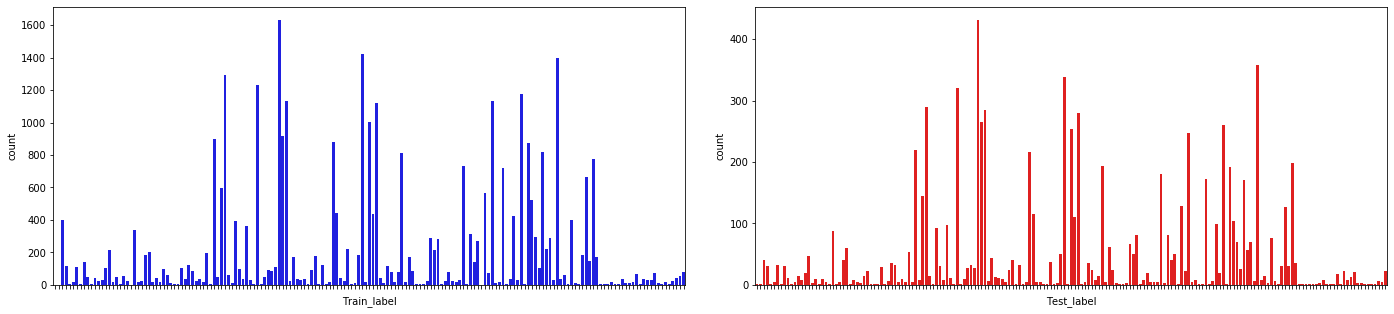

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns 
train_lb = pd.DataFrame(df_train['최종처리그룹'].value_counts())
train_lb = train_lb.reset_index()
train_lb.columns = ['Train_label','count']

test_lb = pd.DataFrame(df_test['최종처리그룹'].value_counts())
test_lb = test_lb.reset_index()
test_lb.columns = ['Test_label','count']

augmented_train_lb = pd.DataFrame(data_augmented['최종처리그룹'].value_counts())
augmented_train_lb = augmented_train_lb.reset_index()
augmented_train_lb.columns = ['Augmented_Train_label', 'count']

# train vs test labels 개수 그래프
f, axes = plt.subplots(1, 2, figsize=(20, 5))
fig_1 = sns.barplot(x='Train_label', y="count", data=train_lb.sort_values(by='Train_label'), ax=axes[0],color="blue").set(xticklabels=[])
fig_2 = sns.barplot(x='Test_label', y="count", data=test_lb.sort_values(by='Test_label'), ax=axes[1],color="red").set(xticklabels=[])
plt.tight_layout(pad=3.0)



<br><br>
B. 보강된 데이터 (2015.01 ~ 2018.06)
- **추가 보강된 데이터도 label별 편차가 보이지만 전체적으로 보완 및 보강된 모습을 보입니다.**

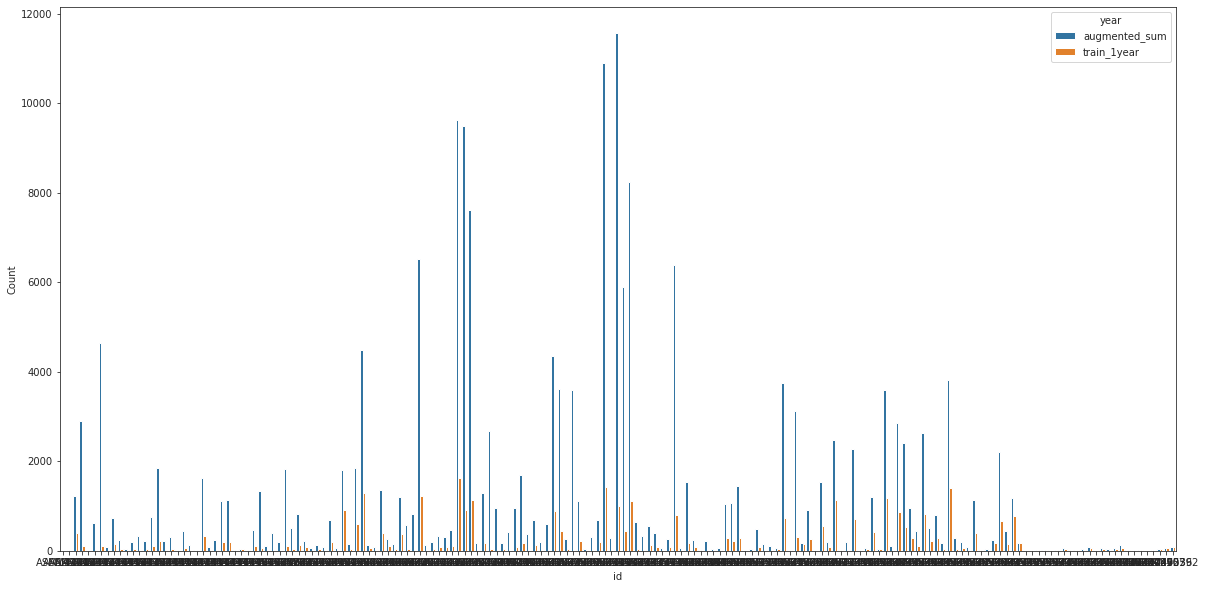

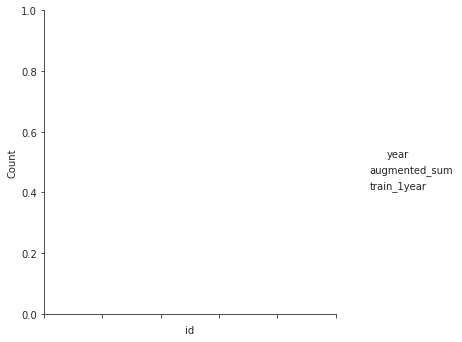

In [33]:
# labels 보강 전 vs 보강 후 그래프
train_label_count = pd.DataFrame(df_train['최종처리그룹'].value_counts())
train_label_count = train_label_count.reset_index()
train_label_count.columns = ['id', 'train_1year']

data_past_label_count = pd.DataFrame(data_past_183['최종처리그룹'].value_counts())
data_past_label_count.reset_index(inplace=True)
data_past_label_count.columns = ['id', 'train_3.5year']

pretrain_label_count = pd.DataFrame(data_augmented['최종처리그룹'].value_counts())
pretrain_label_count.reset_index(inplace=True)
pretrain_label_count.columns = ['id', 'augmented_sum']

train_12 = pd.merge(train_label_count, data_past_label_count , on="id", how='left')
train_sum = pd.merge(train_12, pretrain_label_count , on="id", how='left')
train_sns = train_sum[['id','train_1year','augmented_sum']]
train_sns.columns = ['id','train_1year','augmented_sum']
df = pd.melt(train_sns, id_vars="id", var_name="year", value_name="Count")

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# plot
# sns.set_style('ticks')
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
# fig.set_size_inches(20, 8.27)
sns.factorplot(x='id', y='Count', hue='year',data=df.sort_values(by='id'), kind='bar', ax=ax).set(xticklabels=[])    
sns.despine()


<br><br>
**5) 데이터 저장 (.tsv)**

- 다양한 NLP Task 모델에 적용할 수 있도록 <code>label</code>, <code>text</code> 로 최종 저장 
- data/augmented_train_data.tsv


In [39]:
# 
import re    
import pandas as pd

title = data_augmented.제목.tolist()
contents = data_augmented.내용.tolist()
temp = zip(title,contents)

augmented_text = list(map(lambda x: str(x[0]) + ' ' + str(x[1]), temp) )
augmented_label = data_augmented.최종처리그룹.tolist()
print('전체 text 개수 :' , len(augmented_text))
print('전체 label 개수 :' , len(augmented_label))

# 전처리하기
pretrain_text_re = []

for i in augmented_text:
    i = re.sub('[^가-힣a-zA-Z]',' ',i).strip().lower() #한글, 영어만
    pattern = re.compile(r'\s\s+')
    temp = re.sub(pattern, ' ', i)
    pretrain_text_re.append(temp.strip().lower()) # 영어 소문자화
    
# 데이터 프레임화
df = pd.DataFrame(augmented_label) 
df['text'] = pretrain_text_re
df.columns= ['label' , 'text']

# 데이터 저장
df.to_csv('data/augmented_train_data.tsv', index=False, header=True, sep="\t")

전체 text 개수 : 192761
전체 label 개수 : 192761


In [40]:
# 저장된 데이터 불러오기
pd.read_csv('data/augmented_train_data.tsv',header = 0,sep = "\t" )

,label,text
0,ASM31688,인터넷 불필요명령삭제요청 고창국사 명령번호 일자 명령삭제부탁해요
1,ASM14284,일접수건 멤버십 마케팅팀 확인사항으로 오포인트 재전환요청합니다 멤버십 마케팅팀 확인...
2,ASM30229,전산접속시 dlp 로그인 정상이나 dlp설치 유도창 발생함 전산접속시 로그인 정상이...
3,ASM30031,인터넷전화 준공수신오류 발생한 부분 확인요청드립니다 인터넷전화 준공수신오류 발생한 ...
4,ASM14405,spm 협력사 평가 기안취소건이 결재요청이 안된다고함 기안취소건 다시 결재요청이 안...
...,...,...
192756,ASM30565,kos 일반전화 일반전화 교환기이동 신청 준공수신으로 확인되어 문의 시스템 상품명 ...
192757,ASM38973,데이터 무료 프로모션 문자 다량 발송 문의 안녕하세요 고객님 월 일 데이터 무료 프...
192758,ASM30037,otm 년 무료 미적용 관련 문의입니다 요금 서비스요청 운영 김수현 금일 상품을 라...
192759,ASM35749,수신이력 확인요청드립니다 mvno고객입니다 프리텔레콤 접수상담사 내선 진정현 요청자...


<br><br>
**6) 메캅 적용 버전 데이터 저장 (.tsv)**

In [ ]:
# # mecab 설치 및 데이터 변환
# # 설치 (설치완료시 생략)
# !bash mecab.sh

# # 메캅 적용
# !bash data/mecab_tokenize.sh data/augmented_train_data.tsv data/augmented_train_data_mecab.tsv

In [42]:
# 저장된 데이터 불러오기
pd.read_csv('data/augmented_train_data_mecab.tsv',header = 0,sep = "\t" )

,label,text
0,ASM31688,인터넷 불 필요 명령 삭제 요청 고창 국사 명령 번호 일자 명령 삭제 부탁 해요
1,ASM14284,일 접 수건 멤버십 마케팅 팀 확인 사항 으로 오 포인트 재 전환 요청 합니다 멤버...
2,ASM30229,전산 접속 시 dlp 로그인 정상 이나 dlp 설치 유도 창 발생 함 전산 접속 시...
3,ASM30031,인터넷 전화 준공 수신 오류 발생 한 부분 확인 요청 드립니다 인터넷 전화 준공 수...
4,ASM14405,spm 협력 사 평가 기 안취 소건 이 결재 요청 이 안 된다고 함 기 안취 소건 ...
...,...,...
192756,ASM30565,kos 일반 전화 일반 전화 교환기 이동 신청 준공 수신 으로 확인 되 어 문 의 ...
192757,ASM38973,데이터 무료 프로모션 문자 다량 발송 문 의 안녕 하 세요 고객 님 월 일 데이터 ...
192758,ASM30037,otm 년 무료 미적 용 관련 문의 입니다 요금 서비스 요청 운영 김수현 금일 상품...
192759,ASM35749,수신 이력 확인 요청 드립니다 mvno 고객 입니다 프리 텔레콤 접수 상 담사 내선...


<br><br>
#### (6) 보강한 데이터로 재실험 - large data


- **메캅 미적용 버전 : best_acc 정확도 0.8060**

In [5]:
!python train.py \
    --train_fn ../data/augmented_train_data.tsv \
    --test_fn ../data/test_data.tsv \
    --model_fn _params/pth/kcbert_aug_nomecab_wr.pth \
    --txt_fn _params/kcbert_aug_nomecab_wr.txt \
    --lr 5e-5 \
    --max_length 256 \
    --batch_size 32 \
    --warmup_ratio 0.0001

2020-10-06 18:48:02.802229: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
|unique_labels| = 183
|train| = 192761 |test| = 8327
Namespace(adam_epsilon=1e-08, batch_size=32, gpu_id=0, lr=5e-05, max_length=256, model_fn='_params/pth/kcbert_aug_nomecab_wr.pth', n_epochs=6, pretrained_model_name='beomi/kcbert-base', test_fn='../data/test_data.tsv', train_fn='../data/augmented_train_data.tsv', txt_fn='_params/kcbert_aug_nomecab_wr.txt', verbose=2, warmup_ratio=0.0001)
========= pretrained_model_name beomi/kcbert-base =========
========= model_fn _params/pth/kcbert_aug_nomecab_wr.pth =========
========= batch_size 32 =========
========= max_length 256 =========
========= learning rate 5e-05 =========
Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias

- **메캅 적용 버전 : best_acc 정확도 0.8110 (Epoch 4)**

In [4]:
!python train.py \
    --train_fn ../data/augmented_train_data_mecab.tsv \
    --test_fn ../data/test_data_mecab.tsv \
    --model_fn _params/pth/kcbert_aug_mecab_wr.pth \
    --txt_fn _params/kcbert_aug_mecab_wr.txt \
    --lr 5e-5 \
    --max_length 256 \
    --batch_size 32 \
    --warmup_ratio 0.0001

2020-10-06 14:07:13.951766: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
|unique_labels| = 183
|train| = 192761 |test| = 8327
Namespace(adam_epsilon=1e-08, batch_size=32, gpu_id=0, lr=5e-05, max_length=256, model_fn='_params/pth/kcbert_aug_mecab_wr.pth', n_epochs=6, pretrained_model_name='beomi/kcbert-base', test_fn='../data/test_data_mecab.tsv', train_fn='../data/augmented_train_data_mecab.tsv', txt_fn='_params/kcbert_aug_mecab_wr.txt', verbose=2, warmup_ratio=0.0001)
========= pretrained_model_name beomi/kcbert-base =========
========= model_fn _params/pth/kcbert_aug_mecab_wr.pth =========
========= batch_size 32 =========
========= max_length 256 =========
========= learning rate 5e-05 =========
Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dens

> 

<br><br>
#### (5) lessons learned

- 과거 3.5년의 데이터를 보강하게 되면서 11개월의 데이터를 사용할 때 보다 정확도가 0.6~0.9%의 상승 효과가 있었습니다.
- 또, Mecab을 적용했을 때 더 높은 accuracy를 산출하는 것을 보면서, 형태소 분석기를 통해 한글 문장을 잘 정제하는 것이 성능을 올리는데 필수 요건임을 확인하였습니다.


<br><br><br><br><br><br><br>
<hr>

작성자 : 박은진